## Load and preprocess data using `movement`
## Imports

In [57]:
from pathlib import Path

from movement.io import load_poses, save_poses
from movement.utils.reports import report_nan_values

# Use function from utils.py, located within the same directory
from utils import reshape_loaded_ds, clean_data

## Define and create paths
First let's find the data folder on the current machine and check its contents.

In [2]:
# Exchange the path to the data folder with the correct one on your system
data_folder = Path("/mnt/Data/in2research2024")
assert data_folder.exists()  # Will raise an error if the path does not exist
print(f"Data will be loaded from {data_folder}")

# The following mouse IDs must be present as subfolders in the data folder
mouse_ids = ["SB019", "SB021"]
for mouse_id in mouse_ids:
    assert (data_folder / mouse_id).exists()
    print(f"Subfolder {mouse_id} has been found")

Data will be loaded from /mnt/Data/in2research2024
Subfolder SB019 has been found
Subfolder SB021 has been found


Now let's create subfolders for saving plots and reports.

In [3]:
# Create folders for plots and reports
plot_folder = data_folder / "plots"
plot_folder.mkdir(exist_ok=True)
print(f"Plots will be saved in {plot_folder}")

report_folder = data_folder / "reports"
report_folder.mkdir(exist_ok=True)
print(f"Reports will be saved in {report_folder}")

Plots will be saved in /mnt/Data/in2research2024/plots
Reports will be saved in /mnt/Data/in2research2024/reports


## Load data into a `movement` dataset
Select a single file containing predicted pose tracks.

In [4]:
mouse_id = "SB019"
file_name = "220719_SB019_FM001_female1_2022-07-19-164002DLC_resnet50_shanice_allNov29shuffle1_196000_filtered.csv"
file_path = data_folder / mouse_id / file_name
print(f"Will load data from {file_path}")

Will load data from /mnt/Data/in2research2024/SB019/220719_SB019_FM001_female1_2022-07-19-164002DLC_resnet50_shanice_allNov29shuffle1_196000_filtered.csv


Load data with `movement` and reshape it to the desired format.

Note that tracking was performed with single-animal DeepLabCut models,
despite the fact that the data contains two animals ("individuals"): "resident" and "intruder".
The keypoint names are prefixed with the animal name, e.g. "resident_nose" and "intruder_nose",
so we'll use that prefix to split the data into two individuals,
see `utils.py/reshape_loaded_ds()` for the implementation.


In [5]:
ds_raw = load_poses.from_dlc_file(file_path, fps=50)
print("Data has been loaded successfully.")

all_keypoints = ds_raw.keypoints.values
keypoints_names = [
    kpt.split("_")[1] for kpt in all_keypoints if kpt.startswith("resident")
]
print(f"Keypoints found: {keypoints_names}")
individuals = ["resident", "intruder"]

ds = reshape_loaded_ds(ds_raw, individuals, keypoints_names)
print(f"Data has been reshaped successfully into a dataset with two individuals: {individuals}")

Data has been loaded successfully.
Keypoints found: ['nose', 'leftear', 'rightear', 'butt', 'neck', 'lefthip', 'righthip', 'leftshoulder', 'rightshoulder', 'lowerback']
Data has been reshaped successfully into a dataset with two individuals: ['resident', 'intruder']


In [6]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 3041, individuals: 2, keypoints: 10, space: 2)
Coordinates:
  * time         (time) float64 24kB 0.0 0.02 0.04 0.06 ... 60.76 60.78 60.8
  * individuals  (individuals) <U8 64B 'resident' 'intruder'
  * keypoints    (keypoints) <U13 520B 'nose' 'leftear' ... 'lowerback'
  * space        (space) <U1 8B 'x' 'y'
Data variables:
    position     (time, individuals, keypoints, space) float64 973kB 1.274e+0...
    confidence   (time, individuals, keypoints) float64 487kB 0.004567 ... 0....
Attributes:
    fps:              50.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      /mnt/Data/in2research2024/SB019/220719_SB019_FM001_fema...

We'll focus on the subset of the time in which both animals are present in the arena.

In [7]:
ds  = ds.sel(time=slice(34, 60.8))  # Time slicing happend in seconds
ds

<xarray.Dataset> Size: 655kB
Dimensions:      (time: 1341, individuals: 2, keypoints: 10, space: 2)
Coordinates:
  * time         (time) float64 11kB 34.0 34.02 34.04 34.06 ... 60.76 60.78 60.8
  * individuals  (individuals) <U8 64B 'resident' 'intruder'
  * keypoints    (keypoints) <U13 520B 'nose' 'leftear' ... 'lowerback'
  * space        (space) <U1 8B 'x' 'y'
Data variables:
    position     (time, individuals, keypoints, space) float64 429kB 590.0 .....
    confidence   (time, individuals, keypoints) float64 215kB 0.3416 ... 0.9966
Attributes:
    fps:              50.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      /mnt/Data/in2research2024/SB019/220719_SB019_FM001_fema...

Let's visualise the tracks.
Replace the keypoint name if you want to visualise a different keypoint.

In [8]:
kpt_to_plot = "neck"

Plot the position of the chosen keypoint across time.

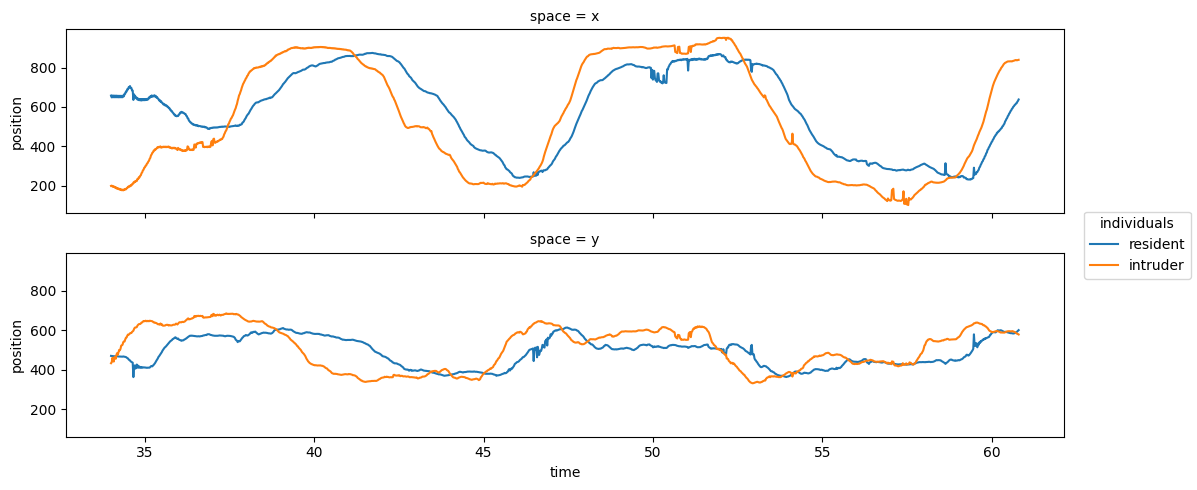

In [9]:
ds["position"].sel(keypoints=kpt_to_plot).plot.line(
    x="time", hue="individuals", row="space", aspect=4, size=2.5
);

Plot confidence for the same keypoint over time

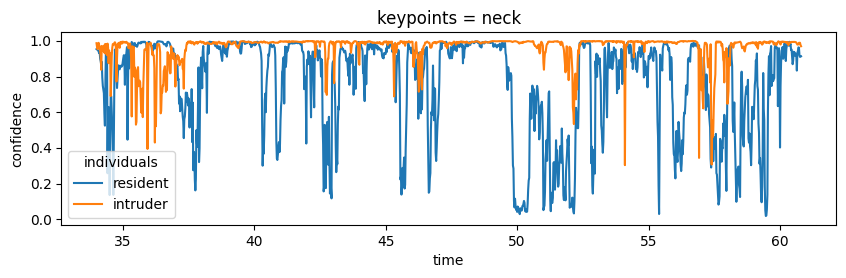

In [10]:
ds["confidence"].sel(keypoints=kpt_to_plot).plot.line(
    x="time", hue="individuals", aspect=4, size=2.5
);

## Clean the data
Apply a number of cleaning steps to the data, see `utils.py/clean_ds()` for more details.

In [39]:
ds_clean = clean_data(
    ds,
    confidence_threshold=0.8,
    interp_max_gap=25,
    smooth_window_size=7,
    smooth_min_periods=2,
)

Let's see how many values we have dropped.

In [40]:
nan_report = report_nan_values(ds_clean["position"], "clean dataset")
print(nan_report)


Missing points (marked as NaN) in clean dataset
	Individual: resident
		nose: 1309/1341 (97.6%)
		leftear: 689/1341 (51.4%)
		rightear: 589/1341 (43.9%)
		butt: 0/1341 (0.0%)
		neck: 243/1341 (18.1%)
		lefthip: 184/1341 (13.7%)
		righthip: 124/1341 (9.2%)
		leftshoulder: 444/1341 (33.1%)
		rightshoulder: 451/1341 (33.6%)
		lowerback: 34/1341 (2.5%)
	Individual: intruder
		nose: 35/1341 (2.6%)
		leftear: 0/1341 (0.0%)
		rightear: 0/1341 (0.0%)
		butt: 55/1341 (4.1%)
		neck: 0/1341 (0.0%)
		lefthip: 209/1341 (15.6%)
		righthip: 600/1341 (44.7%)
		leftshoulder: 292/1341 (21.8%)
		rightshoulder: 412/1341 (30.7%)
		lowerback: 59/1341 (4.4%)


Let's visualise the data before and after the cleaning steps.

In [53]:
kpt_to_plot = "neck"

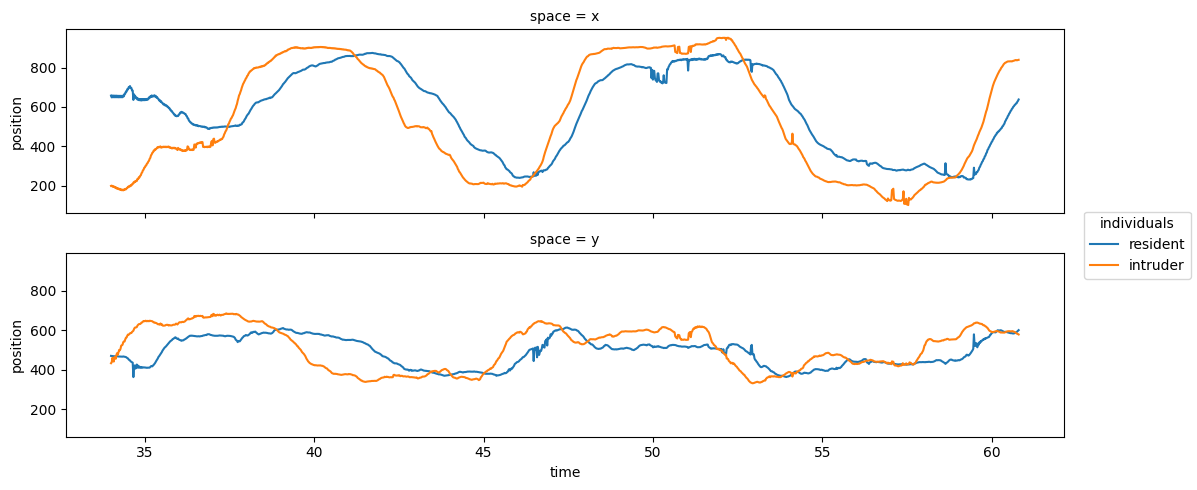

In [54]:
ds["position"].sel(keypoints=kpt_to_plot).plot.line(
    x="time", hue="individuals", row="space", aspect=4, size=2.5
)

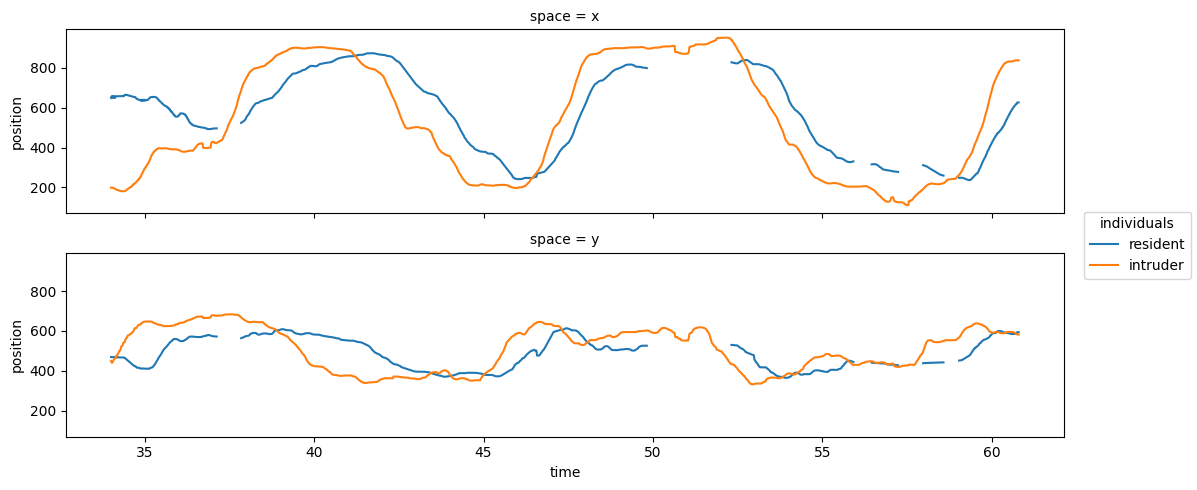

In [55]:
ds_clean["position"].sel(keypoints=kpt_to_plot).plot.line(
    x="time", hue="individuals", row="space", aspect=4, size=2.5
);

Let's save the cleaned data to a new file.

In [58]:
file_name_clean = file_name.replace(".csv", "_clean.csv")
file_path_clean = data_folder / mouse_id / file_name_clean
save_poses.to_dlc_file(
    ds_clean, file_path_clean, split_individuals=False,
)

Let's also save the nan report to a file.

In [59]:
report_path = report_folder / f"{file_name_clean.replace('.csv', '_report.txt')}"
with open(report_path, "w") as f:
    f.write(nan_report)